<a href="https://colab.research.google.com/github/MateoMu/TDS_III/blob/master/Proyecto_final_MateoMu%C3%B1ozArroyave_TDS_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

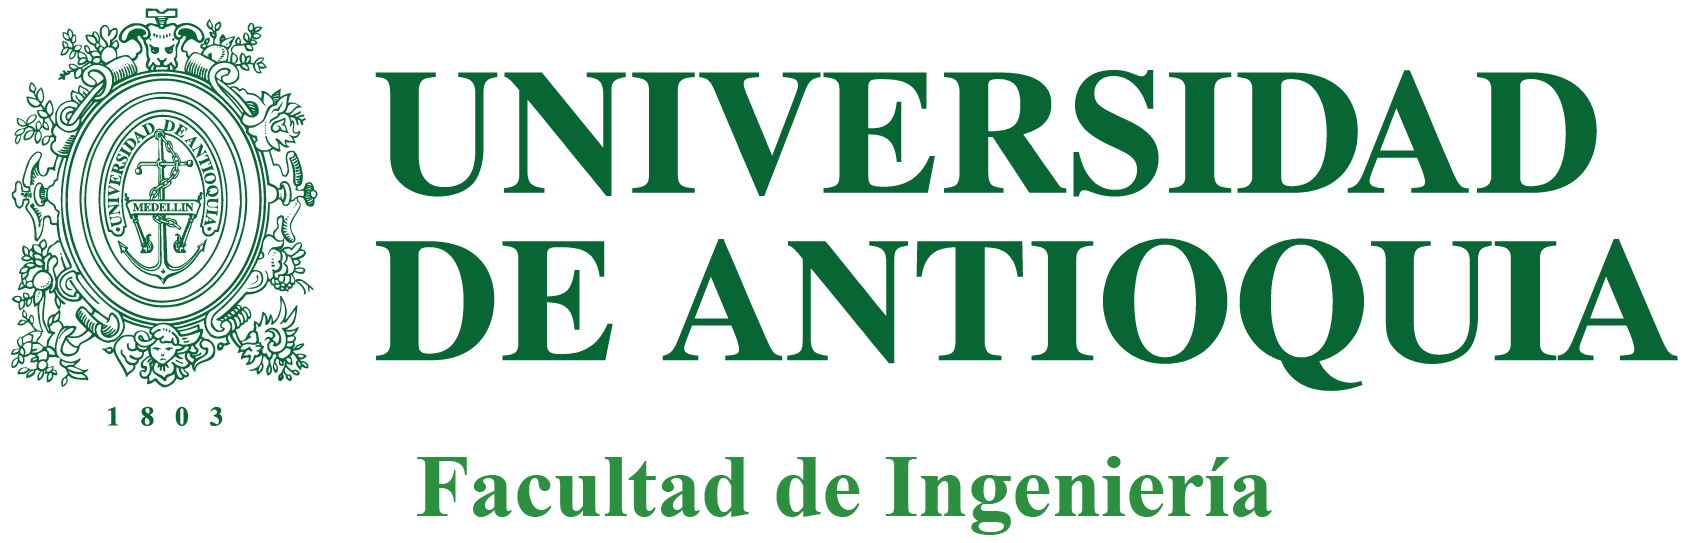
---
- **Asignatura:** Tratamiento de Señales III
- **Profesor:** Hernán Felipe García Arias
- **Alumno:** Mateo Muñoz Arroyave C.C 1036676919
- **Ingeniería de Telecomunicaciones**
- **UdeA**
- **2023-2**

---

## Final Project Assignment: Modulation Recognition Using Convolutional Neural Networks (CNN) with Database


**Objective:**
- The objective of this final project is to design and implement a modulation recognition system using Convolutional Neural Networks (CNN). The project will involve building a robust CNN model capable of accurately classifying different modulation schemes present in the provided database (RadioML2016). Modulation recognition is a crucial task in wireless communication systems, and your implementation will contribute to the advancement of signal processing in communications.

**Dataset:**
- You will be provided with a dataset (Database RadioML2016) containing samples of signals with various modulation schemes. The dataset is divided into training and testing sets. It is essential to preprocess the data appropriately to feed it into the CNN model.

**Tasks:**

1. Data Preprocessing: Load and explore the dataset to understand its structure and characteristics.
Preprocess the data, including normalization, resizing, and any other necessary steps to prepare it for input into the CNN.
2. CNN Model Architecture:
Design a CNN architecture suitable for modulation recognition. Consider the input shape, number of layers, filter sizes, and activation functions.
Implement the CNN model using a deep learning framework of your choice (e.g., TensorFlow, PyTorch, Keras).
3. Training: Split the dataset into training and validation sets.
Train the CNN model using the training set, monitoring and optimizing for performance on the validation set.
Experiment with different hyperparameters to enhance the model's accuracy.
4. Evaluation: Evaluate the trained model on the testing set to assess its performance in recognizing modulation schemes.
Calculate relevant metrics such as accuracy, precision, recall, and F1 score.
5. Analysis and Visualization: Provide visualizations of the training/validation loss and accuracy over epochs.
Analyze the confusion matrix to understand the model's performance on different modulation schemes.
6. Documentation: Prepare a comprehensive notebook report documenting the entire project, including data exploration, model architecture, training process, evaluation results, and analysis. Include code documentation and comments for clarity.
7. Presentation: Prepare a pitch presentation summarizing key aspects of your project.
Present the motivation, methodology, results, and any challenges faced during the implementation.
8. Submission Guidelines: Submit the project code along with a README file providing instructions on how to run the code (use GIT).
9. Submit the project report in a clear and organized format on GIT repo.
10. Ensure that your implementation is well-documented, and your code follows best practices.


*This final project will not only test your understanding of modulation recognition and CNNs but also your ability to apply machine learning concepts to real-world signal processing challenges.*

Good luck!

##Librerías a utilizar

In [51]:
import os,random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, sys
%matplotlib inline
from tensorflow import keras
from keras.utils import to_categorical
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

In [52]:
!gdown '1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K'

Downloading...
From: https://drive.google.com/uc?id=1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K
To: /content/RML2016.10a_dict.pkl
100% 641M/641M [00:08<00:00, 78.5MB/s]


##Procesamiento de los datos

In [53]:
# Load the dataset ...
#  You will need to seperately download (radioml.com) or generate this file
with open("RML2016.10a_dict.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding="latin1")

In [54]:
# Calculate modulations and signal-to-noise ratios contained in dataset
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

print('These are the modulation schemes in the dataset: {}'.format(mods))
print('These are the signal to noise ratios in the dataset: {}'.format(snrs))

These are the modulation schemes in the dataset: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
These are the signal to noise ratios in the dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [55]:
np.shape(Xd['BPSK', -18])

(1000, 2, 128)

La base de datos se extrae de un conjunto de datos de GNU Radio, que presenta una distribución compuesta por 1000 muestras. Cada muestra contiene 128 datos y está asociada a once tipos de modulaciones diferentes, así como a veinte relaciones señal-ruido que han sido objeto de análisis. Es importante resaltar que la segunda dimensión de los datos tiene un valor de 2, indicando que corresponde a las componentes I-Q (In-Phase y Quadrature).

###Muestra de una modulación al ser afectada por varias SNR

In [56]:
'''
Compute the original RF signal from the I & Q components.
'''
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 1e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

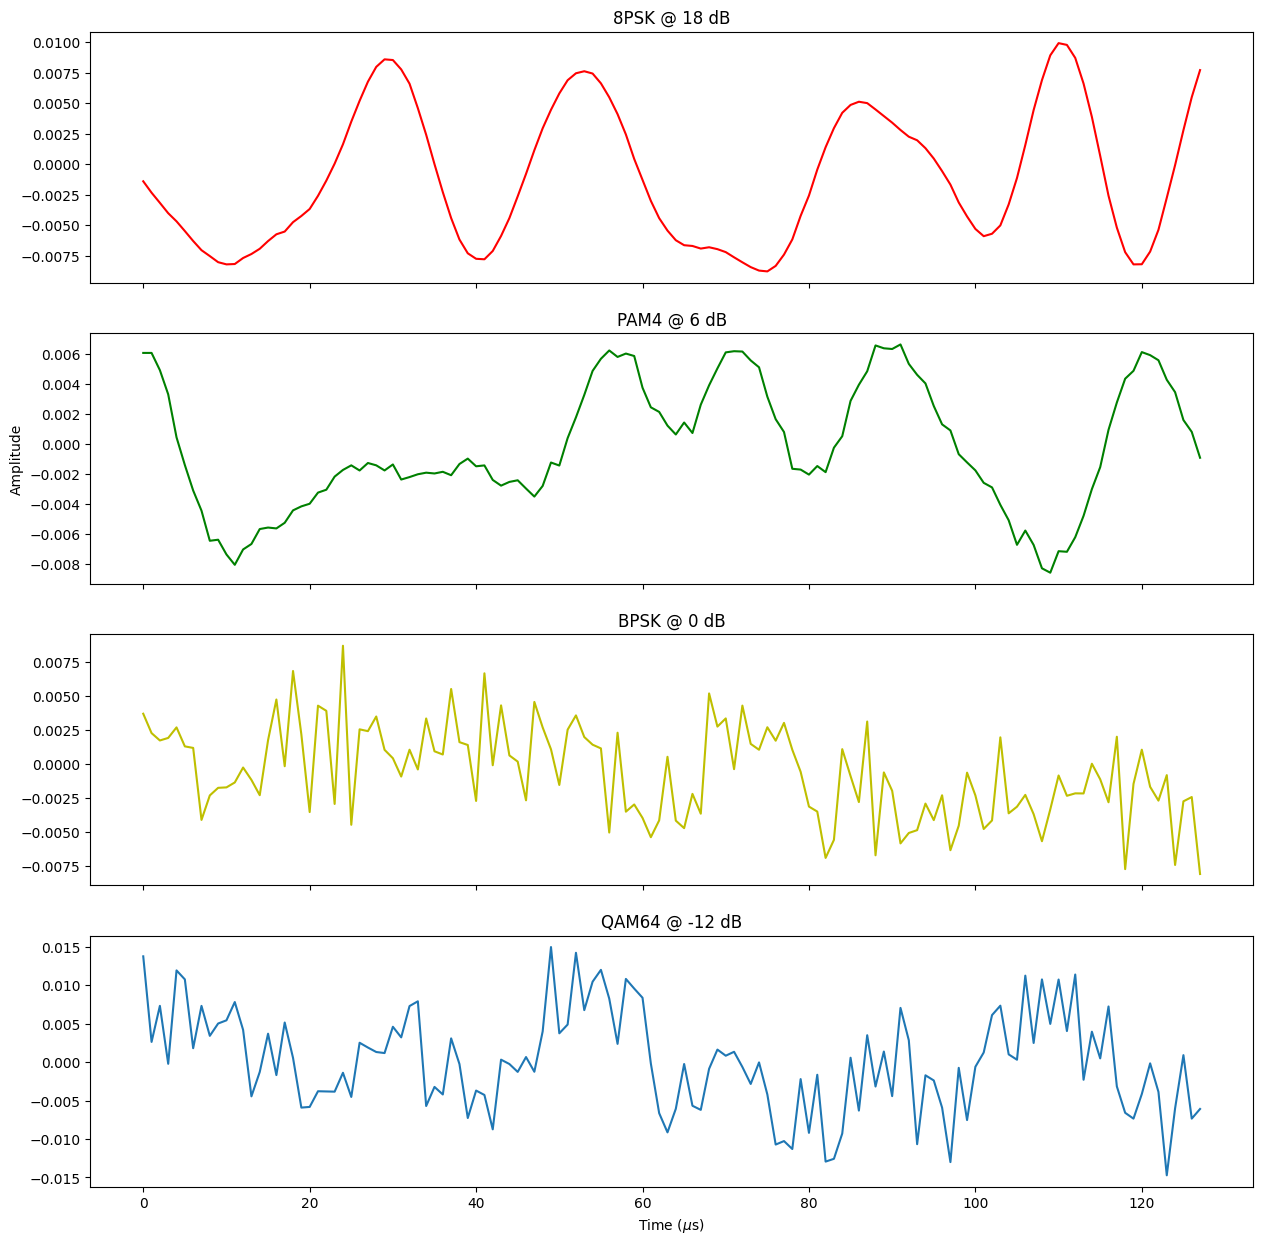

In [57]:
# Plot some of the data
nFigs = 4

plt.figure(figsize=(15, 15))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(reconstructSignal(Xd['8PSK', 18][2,:,:]), color='r');
plt.title('8PSK @ 18 dB')

ax2 = plt.subplot(nFigs, 1, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd['PAM4', 6][99,:,:]), color='g');
plt.title('PAM4 @ 6 dB')

plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 1, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd['BPSK', 0][456,:,:]), color='y');
plt.title('BPSK @ 0 dB')

ax4 = plt.subplot(nFigs, 1, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd['QAM64', -12][32,:,:]));
plt.title('QAM64 @ -12 dB')

# We only need to show the xticks on the bottom subplot
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlabel(r'Time ($\mu$s)');

###Construccion de la matriz
A continuación, con el objetivo de gestionar la información de manera más eficiente, se procede a construir una matriz utilizando el conjunto de datos. Es importante considerar la distribución previamente mencionada de la información, ya que esta determinará la estructura específica que adoptará la matriz. Este paso es fundamental para asegurar una representación adecuada y coherente de los datos en la matriz resultante.

In [58]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
X.shape

(220000, 2, 128)

###Se añade ruido a la matriz

In [59]:
numNoiseSamples = 20000 # Add 20,000 samples of just Gaussian noise
for i in range(numNoiseSamples):
    lbl.append(['Noise', snrs[i%len(snrs)]])

mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  # Add noise to the end of the data

###Cada modulacion como un codigo binario

In [60]:
lbl = np.array(lbl) # Convert from list to numpy array (for speed)

# This will encode the labels into a binary array.
# This is referred to as One-Hot.
# Each element of the array is either 1 or 0.
# The position of the element refers to which type of modulation.
# So if there are 11 modulation types, then the
# array is length 11.
# e.g.  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] codes '8PSK'
#       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] codes 'AM-DSB'
#       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] codes 'WBFM'
# We'll use this to compare the output of the neural network
# and help train the model to give the lowest error (in this case
# the cost will be the cross-entropy).
y_encoded = LabelBinarizer().fit_transform(lbl[:,0])

print(y_encoded.shape)

(240000, 12)


In [61]:
lbl[:10,0]

array(['8PSK', '8PSK', '8PSK', '8PSK', '8PSK', '8PSK', '8PSK', '8PSK',
       '8PSK', '8PSK'], dtype='<U21')

In [62]:
lbl[:10,1]

array(['-20', '-20', '-20', '-20', '-20', '-20', '-20', '-20', '-20',
       '-20'], dtype='<U21')

In [63]:
y_encoded[-10:]

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

###Se devididen los datos de entrenamiento y test

In [64]:
# Partition the data
#  into training and test sets of the form we can train/test on
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)

# Now get a list of random indicies to sample for the training set
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# Testing set is whatever indicies are left over
test_idx = list(set(range(0,n_examples))-set(train_idx))

# Now split up the data by the random indicies
X_train = X[train_idx]
X_test =  X[test_idx]
Y_train = y_encoded[train_idx]
Y_test = y_encoded[test_idx]

In [65]:
print('Training set is {}'.format(np.shape(X_train)))
print('Test set is {}'.format(np.shape(X_test)))

Training set is (168000, 2, 128)
Test set is (72000, 2, 128)


###Construcción del modelo NN
Su tarea aquí es codificar 2 arquitecturas CNN para evaluar el reconocimiento de modulación utilizando enfoques de aprendizaje profundo.

In [66]:
X_train = X_train.reshape(X_train.shape[0], 2, 128, 1)
X_test = X_test.reshape(X_test.shape[0], 2, 128, 1)

# Build CNN Neural Net model using tensorflow  --
#  - Reshape [N,2,128] to [N,2,128,1] on input
#  - Pass through 3 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.6 # dropout rate (%) = percentage of neurons to randomly lose each iteration
model = models.Sequential()  # Neural network is a set of sequential layers
#model.add(Convolution2D(...))
model.add(Convolution2D(filters=16, kernel_size=(1,9), padding='same', strides=(1,2), activation='relu', input_shape=(2,128,1)))

model.add(Convolution2D(filters=32, kernel_size=(1,9), padding='same', strides=(1,2), activation='relu'))

model.add(Convolution2D(filters=64, kernel_size=(1,9), padding='same', strides=(1,2), activation='relu'))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(12, activation='softmax'))

# Take a look at the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 2, 64, 16)         160       
                                                                 
 conv2d_7 (Conv2D)           (None, 2, 32, 32)         4640      
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 16, 64)         18496     
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)              

###Compilación del modelo

In [67]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

###Entrenar el modelo

In [68]:
# Set up some params
nb_epoch = 200     # number of epochs to train on
batch_size = 1024  # training batch size

In [69]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = './'
modelWeightsFile = filepath + 'PESOS_TSIII.wts.h5'  # Save the model weights to this file

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(modelWeightsFile)

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.80600, saving model to ./PESOS_TSIII.wts.h5
165/165 - 4s - loss: 2.1404 - accuracy: 0.2125 - val_loss: 1.8060 - val_accuracy: 0.3340 - 4s/epoch - 23ms/step
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.80600 to 1.62756, saving model to ./PESOS_TSIII.wts.h5
165/165 - 2s - loss: 1.7510 - accuracy: 0.3411 - val_loss: 1.6276 - val_accuracy: 0.3845 - 2s/epoch - 11ms/step
Epoch 3/200

Epoch 3: val_loss improved from 1.62756 to 1.53080, saving model to ./PESOS_TSIII.wts.h5
165/165 - 2s - loss: 1.6177 - accuracy: 0.3855 - val_loss: 1.5308 - val_accuracy: 0.4127 - 2s/epoch - 10ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 1.53080
165/165 - 2s - loss: 1.5401 - accuracy: 0.4099 - val_loss: 1.5735 - val_accuracy: 0.4038 - 2s/epoch - 11ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 1.53080
165/165 - 3s - loss: 1.7820 - accuracy: 0.3580 - val_loss: 1.5616 - val_accuracy: 0.4186 - 3s/epoch - 17ms/step
Epoch 6/200

Epoch 6: val_loss improved from 1.53080 to 1.44583, saving model to ./PESOS_TSIII.wts.h5
165/165 - 2s - loss: 1.5648 - accuracy: 0.4166 - val_loss: 1.4458 - val_accuracy: 0.4437 - 2s/epoch - 11ms/step
Epoch 7/200

Epoch 7: val_

In [70]:
# Evaluate the model on test set
score = model.evaluate(X_test, Y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.5750972032546997


- Al incrementar el strides, el modelo tarda más épocas en alcanzar el punto óptimo, como se evidencia en el registro de épocas y el Early Stopping.

- Relacionando esto con los valores de las épocas y la evolución de la precisión, se puede notar que, en general, el modelo muestra un progreso en la precisión a medida que avanza el entrenamiento, aunque con fluctuaciones. El registro muestra la mejora progresiva de la precisión en el conjunto de validación (val_accuracy) a lo largo de las épocas. Sin embargo, el modelo experimenta un estancamiento y eventualmente se detiene mediante Early Stopping después de 54 épocas sin una mejora significativa

###Evaluacion modelo

In [71]:
y_predict = model.predict(X_test, batch_size=batch_size)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(y_predict, axis=1)))

71/71 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.53      0.50      0.51      5957
           1       0.53      0.73      0.61      5852
           2       0.26      0.97      0.41      5932
           3       0.90      0.57      0.70      6051
           4       0.80      0.59      0.68      5963
           5       0.87      0.63      0.73      6022
           6       1.00      1.00      1.00      6125
           7       0.87      0.67      0.75      5991
           8       0.37      0.08      0.13      5906
           9       0.52      0.67      0.59      6029
          10       0.81      0.32      0.46      6072
          11       0.82      0.17      0.29      6100

    accuracy                           0.58     72000
   macro avg       0.69      0.58      0.57     72000
weighted avg       0.69      0.58      0.57     72000



Es importante destaca las métricas de precisión, recall y F1-score para cada clase en un problema de clasificación. Estas métricas proporcionan una visión detallada del rendimiento del modelo para cada categoría. Se hace una relación analitica con los datos proporcionados:

- Precisión:

  El análisis menciona que la precisión se comporta bien para todas las clases, excepto para la clase 2, donde su valor es muy bajo. Al revisar los datos, se confirma que la precisión es más baja para la clase 2 (0.26) en comparación con otras clases.

- Recall:

  Se señala que las clases 8, 10 y 11 tienen un valor muy bajo de recall, indicando que el modelo tiene dificultades para detectar señales o patrones de esas clases. Al verificar los datos, se confirma que el recall es bajo para las clases 8, 10 y 11 (0.09, 0.36, 0.20, respectivamente).

- F1-score:

  El análisis destaca que el F1-score es muy pequeño para las clases 8, 10 y 11, ya que es un promedio entre la precisión y el recall. Al revisar los datos, se confirma que el F1-score es bajo para las clases 8 y 11 (0.14, 0.32, respectivamente).

El modelo tiene un rendimiento desigual en diferentes clases, con algunas clases (como la 2, 8, 10, 11) mostrando dificultades significativas. Se debe tener en cuenta la importancia de evaluar el rendimiento del modelo en cada clase individualmente, ya que los resultados agregados pueden ocultar problemas específicos. Además, el análisis destaca áreas específicas que podrían necesitar mejoras para lograr un rendimiento más equitativo en todas las clases.

### Curva de perdidas

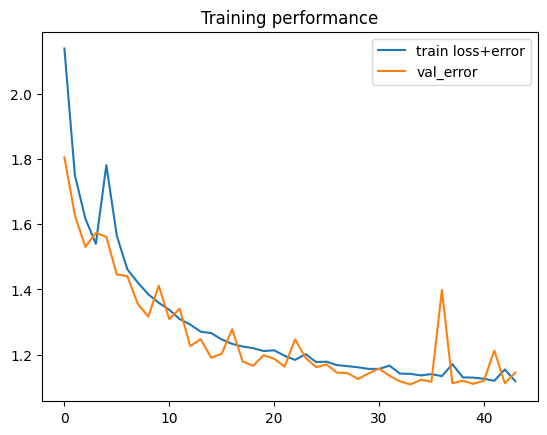

In [72]:
# Show loss curves
plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

Para un análisis detallado de las curvas de pérdida revela un proceso de aprendizaje efectivo en el modelo, evidenciado por la coherencia entre las tendencias de las pérdidas de entrenamiento y validación. Aunque se presenta una brecha inicial entre ambas pérdidas, atribuible a las fases iniciales del entrenamiento, se destaca una mejora progresiva a lo largo de las épocas, culminando con una diferencia renovada. Este fenómeno sugiere que, a medida que el modelo asimila más información de los datos, la pérdida de validación permanece consistentemente por debajo de la pérdida de entrenamiento hasta un punto donde se cruzan, indicando una capacidad de generalización y ajuste adecuados del modelo a los patrones presentes en los datos suministrados.

La rápida asimilación de características generales de las modulaciones, evidenciada por la disminución significativa del error, sugiere un aprendizaje eficiente del modelo. La detención del entrenamiento en la época 40, acompañada de la convergencia entre las curvas de entrenamiento y validación, señala un equilibrio donde el modelo ha alcanzado su capacidad máxima de reducción de error o ha evitado el sobreajuste. La intersección entre ambas curvas indica un rendimiento equitativo en ambos conjuntos, descartando sobreajuste o subajuste. A pesar de este rendimiento aceptable, el nivel de error relativamente alto sugiere que el modelo podría beneficiarse de más datos o de una exploración de arquitecturas alternativas para lograr una optimización más efectiva.

###Matriz de confusión

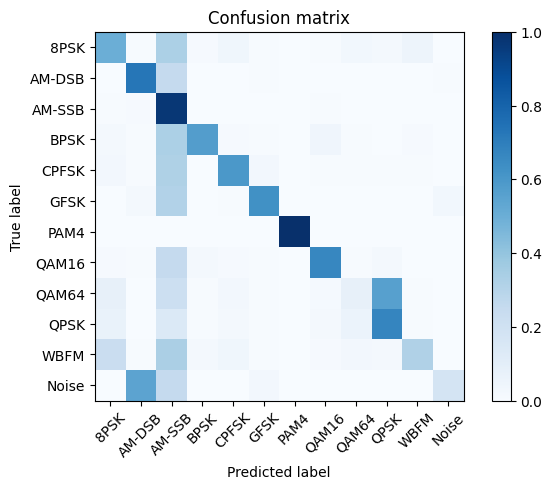

In [73]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot confusion matrix
classes = mods
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(y_predict[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)


112/112 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -20: 0.16876222408493993
113/113 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -18: 0.17612849626142343
115/115 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -16: 0.1757310740639519
114/114 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -14: 0.18073951434878588
115/115 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -12: 0.22754654983570646
116/116 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -10: 0.29978296256104175
111/111 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -8: 0.41080011309018943
112/112 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -6: 0.5438007276798209
112/112 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -4: 0.6307563494278537
114/114 [==============================] - 0s 3ms/step
Overal

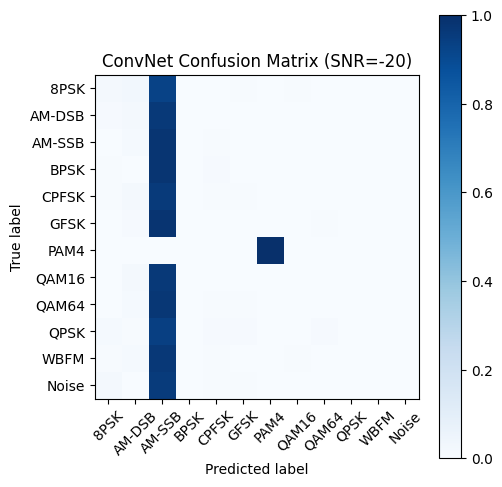

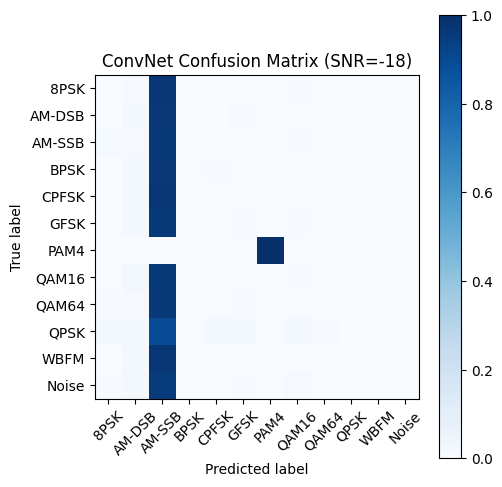

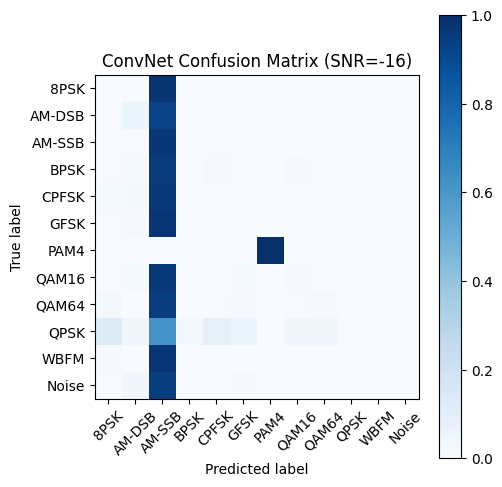

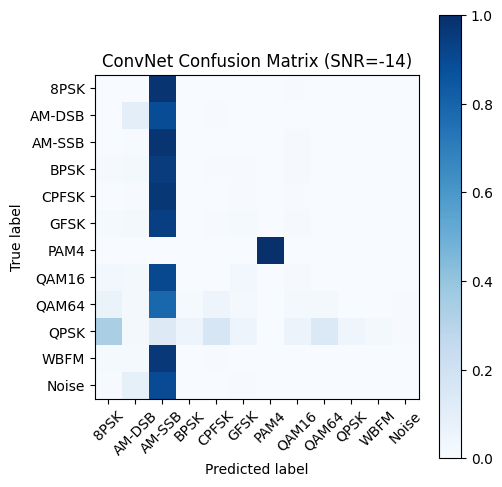

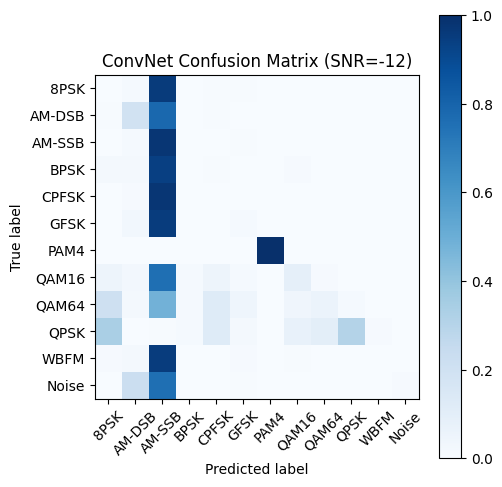

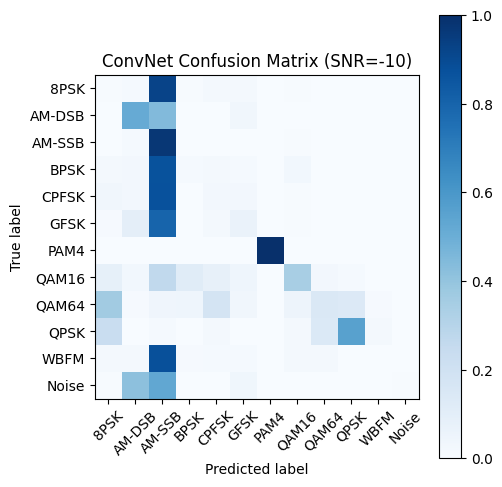

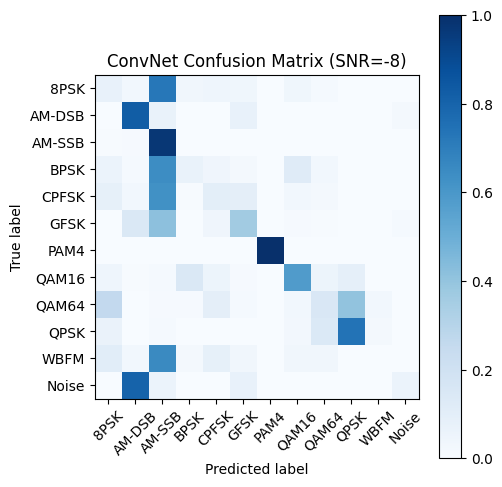

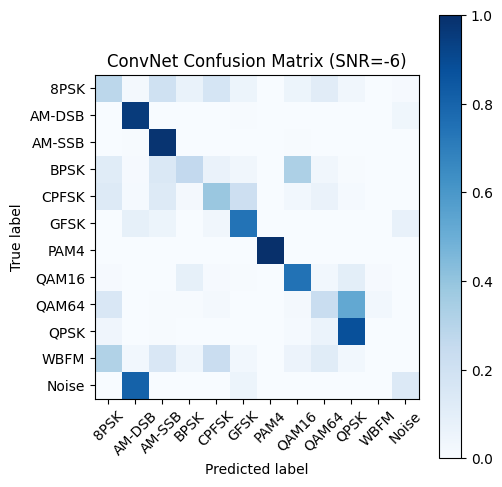

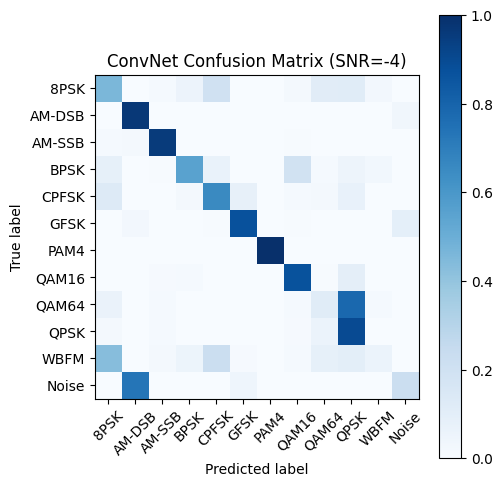

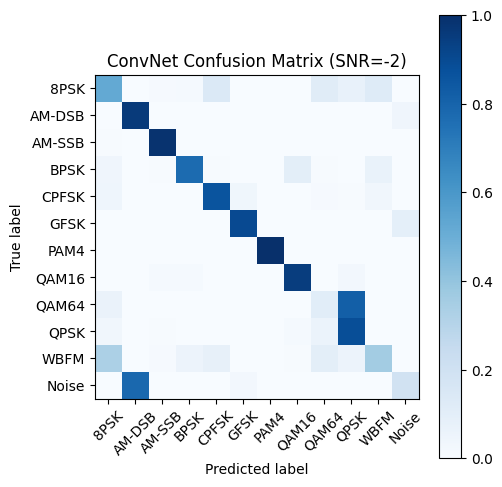

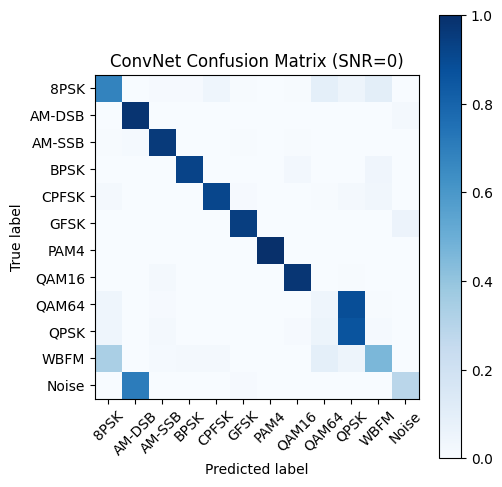

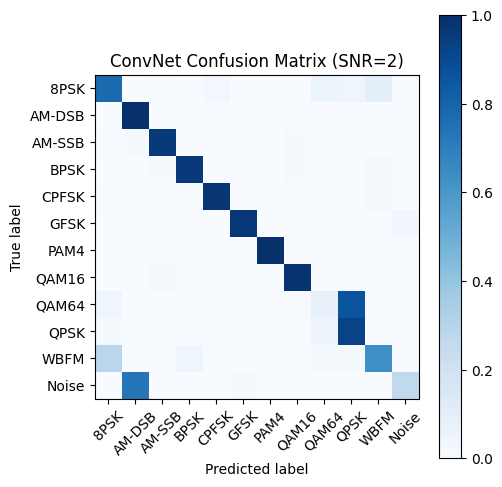

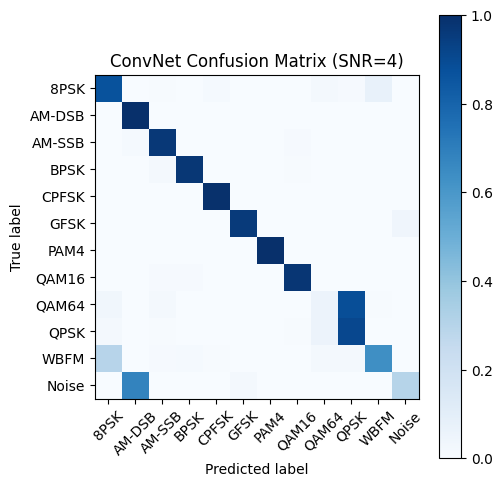

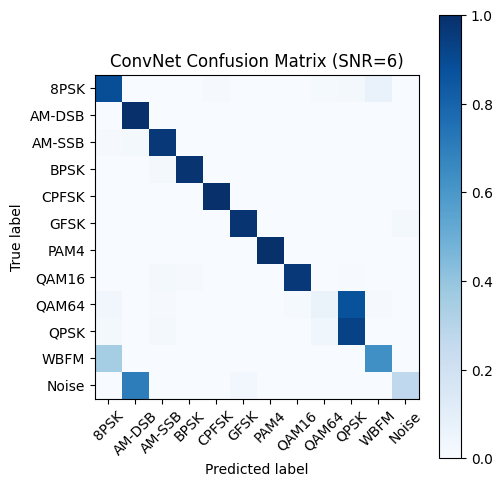

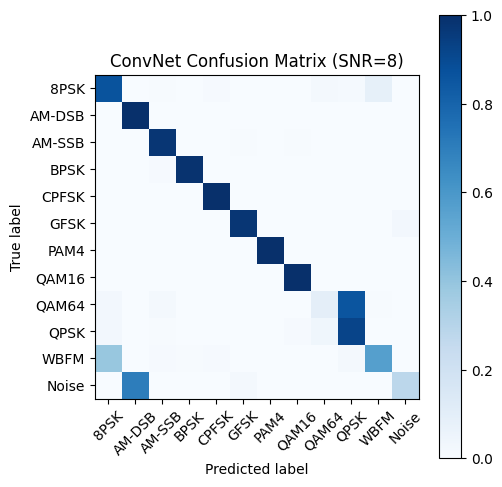

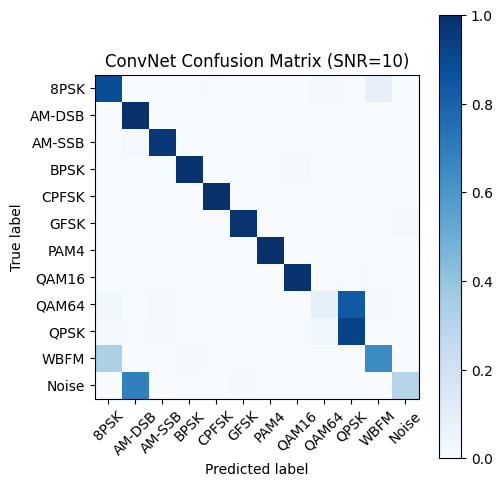

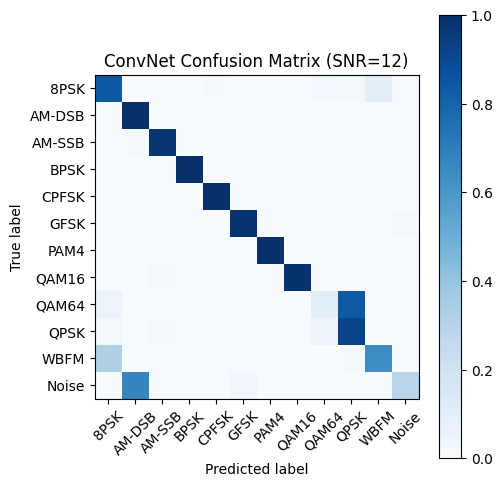

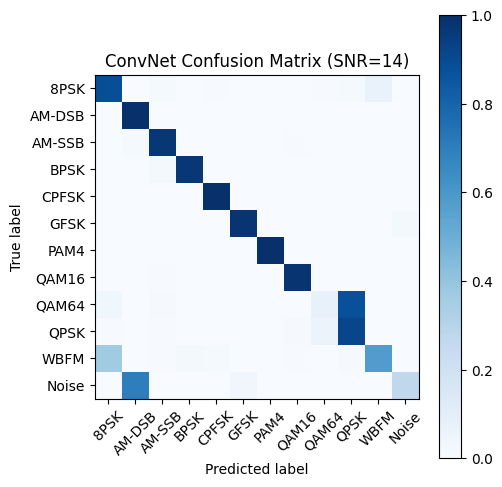

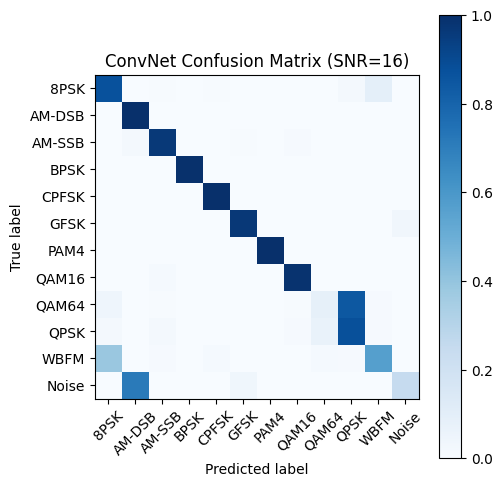

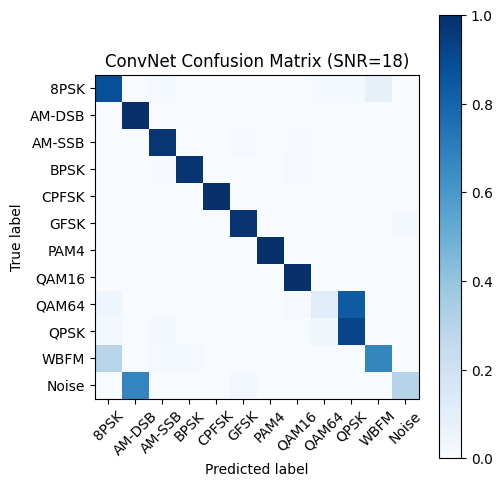

In [74]:
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: int(lbl[x][1]), test_idx)
    test_S = []
    for i in test_SNRs:
      test_S.append(i)
    test_S = np.array(test_S)
    test_X_i = X_test[np.where(test_S == snr)]
    test_Y_i = Y_test[np.where(test_S == snr)]

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)

Para las matrices de confusión y la métrica de precisión revela patrones distintivos en la calidad de las predicciones para diferentes niveles de relación señal-ruido (SNR). En particular, para SNR negativas, caracterizadas por niveles elevados de ruido, las predicciones exhiben una marcada imprecisión, reflejando la dificultad del modelo para discernir patrones significativos en medio de condiciones adversas. Ademas, para SNR positivas, donde el ruido disminuye, se observa una mejora sustancial en la precisión de las predicciones. Este comportamiento resalta la sensibilidad del modelo a las condiciones de ruido, siendo crucial considerar este factor al evaluar y entender el rendimiento del modelo de cara a diferentes niveles de SNR

###Curva de precision

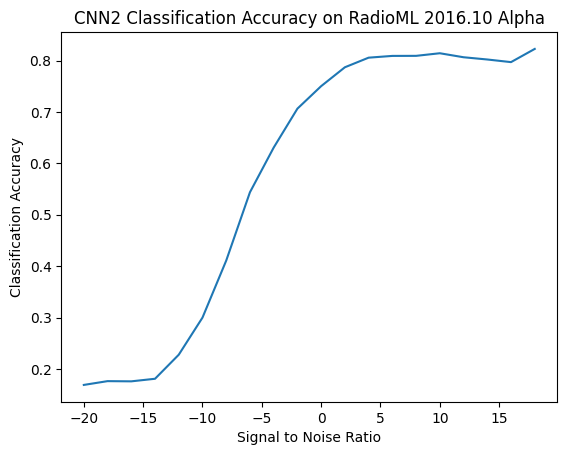

In [75]:
# Plot accuracy curve
a =  map(lambda x: acc[x], snrs)
aux = []
for i in a:
  aux.append(i)
plt.plot(snrs, aux);
plt.xlabel("Signal to Noise Ratio");
plt.ylabel("Classification Accuracy");
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha");

##**Conclusiones**

* La implementación de redes neuronales se revela crucial, ya que posibilita el aprendizaje de patrones complejos, ajustando sus parámetros para mejorar el rendimiento con la adición de más información, abarcando tareas diversas, desde reconocimiento de patrones hasta procesamiento de lenguaje natural.

* La introducción de capas de activación aporta no linealidad, permitiendo a la red aprender y representar relaciones complejas en los datos. Variar funciones de activación y capas mejora la adaptabilidad del modelo.

* El aumento del tamaño del kernel en redes neuronales convolucionales facilita la captura de patrones más complejos y mejora la precisión al permitir que el modelo aprenda patrones más amplios y significativos en los datos.

* Un paso grande en la convolución puede reducir la resolución espacial de la salida, causando pérdida de información. Ajustar este valor es crucial para preservar detalles importantes en el modelo.

* La variación del paso afecta la convergencia y la ubicación de mínimos locales. La aplicación de "Early Stopping" es útil para determinar cuándo detener el entrenamiento y evitar el sobreajuste.

* La precisión, recall y F1-score proporcionan información clave sobre el rendimiento del modelo en diferentes clases. Identificar clases con bajo rendimiento es crucial para mejorar la capacidad de generalización.

* La matriz de confusión ofrece detalles sobre cómo el modelo clasifica diferentes clases, destacando áreas de confusión. Analizar las celdas fuera de la diagonal principal ayuda a comprender dónde el modelo puede mejorar.

* El desequilibrio en el rendimiento de clases sugiere ajustar el equilibrio de clase, aplicar técnicas de aumento de datos o ajustar hiperparámetros específicos para mejorar el rendimiento de clases sobreentrenadas.

* La complejidad de un modelo, medida por el número de parámetros, impacta en su capacidad para aprender patrones. La inclusión de técnicas de regularización, como Batch Normalization y Dropout, puede mejorar la generalización del modelo ya que para este metodo son mas datos los que entrena, pero para este se decidio utilizar Dropout sin normalizar, ajustando el valor de kernel, ya que a medida que es mayor nos da una mejor precisión.

* En el contexto de reconocimiento de modulación, las redes CNN desempeñan un papel crítico al adaptarse a la diversidad de señales, facilitando la optimización del receptor y alertando sobre posibles amenazas en el espectro.
